In [229]:
import pandas as pd
import os
import re
import sys
import matplotlib.pyplot as plt

In [230]:
sys.path.append('../statistics')
from mylib import mylibrary as ml

In [231]:
def get_df(path):
    csv = ml.get_csv(path)
    df = ml.dict_to_df(ml.get_data(csv))
    sumdata = ml.sum_data(df)
    timedata = ml.time_data(df)
    sumdata = sumdata.reindex(sorted(sumdata.columns), axis=1)
    timedata = timedata.reindex(sorted(timedata.columns), axis=1)
    #sumdata = sumdata.drop(['sat', 'unsat', 'segfault', 'other', 'timeout']).T
    return sumdata, timedata
    

# Original

In [232]:
orig_dir = ! pwd
orig_dir= orig_dir[0] + "/original"

In [233]:
orig_sum,orig_time = get_df(orig_dir)
orig_sum_solved = orig_sum.drop(['sat', 'unsat', 'segfault', 'other', 'timeout']).T.rename(columns={"solved": "orig"})
orig_sum

,2017-Preiner-UltimateAutomizer,2017-Preiner-keymaera,2017-Preiner-psyco,2017-Preiner-scholl-smt08,2017-Preiner-tptp,20170501-Heizmann-UltimateAutomizer,2018-Preiner-cav18,20190429-UltimateAutomizerSvcomp2019,2020-Preiner-fmcad20,20210301-Alive2,20210301-Alive2-partial-undef,20230321-UltimateAutomizerSvcomp2023,llvm13-smtlib,wintersteiger
total,153,4035,194,374,73,131,600,96,165,4,3,140,9,181
unsat,137,3904,48,48,56,90,563,71,128,0,1,94,1,91
sat,16,104,103,240,17,20,0,15,0,0,0,13,0,82
solved,153,4008,151,288,73,110,563,86,128,0,1,107,1,173
timeout,0,27,43,69,0,17,37,10,37,2,2,33,8,7
segfault,0,0,0,0,0,0,0,0,0,0,0,0,0,0
other,0,0,0,17,0,4,0,0,0,2,0,0,0,1


# Approx of, abstr of

In [234]:
current_dir = ! pwd
current_dir = current_dir[0] + "/approx_of_abstr_of/"
current_dir

'/var/tmp/vcloud-q3b/statistics_final/approx_of_abstr_of/'

In [235]:
none_sum,ofof_time = get_df(current_dir)
none_sum_solved = none_sum.drop(['sat', 'unsat', 'segfault', 'other', 'timeout']).T.rename(columns={"solved": "none"})

# Approx on, abstr of

In [236]:
current_dir = ! pwd
current_dir = current_dir[0] + "/approx_on_abstr_of/"
current_dir

'/var/tmp/vcloud-q3b/statistics_final/approx_on_abstr_of/'

In [237]:
approx_sum,ofof_time = get_df(current_dir)
approx_sum_solved = approx_sum.drop(['sat', 'unsat', 'segfault', 'other', 'timeout']).T.rename(columns={"solved": "approx"})

# Approx of, abstr on

In [238]:
current_dir = ! pwd
current_dir = current_dir[0] + "/approx_of_abstr_on/"
current_dir

'/var/tmp/vcloud-q3b/statistics_final/approx_of_abstr_on/'

In [239]:
abstr_sum,ofof_time = get_df(current_dir)
abstr_sum_solved = abstr_sum.drop(['sat', 'unsat', 'segfault', 'other', 'timeout']).T.rename(columns={"solved": "abstr"})
abstr_sum_solved

,total,abstr
2017-Preiner-UltimateAutomizer,153,153
2017-Preiner-keymaera,4035,4009
2017-Preiner-psyco,194,152
2017-Preiner-scholl-smt08,374,286
2017-Preiner-tptp,73,73
20170501-Heizmann-UltimateAutomizer,131,109
2018-Preiner-cav18,600,563
20190429-UltimateAutomizerSvcomp2019,96,86
2020-Preiner-fmcad20,165,129
20210301-Alive2,4,0


# Approx on, abstr on

In [240]:
current_dir = ! pwd
current_dir = current_dir[0] + "/approx_on_abstr_on/"
current_dir

'/var/tmp/vcloud-q3b/statistics_final/approx_on_abstr_on/'

In [241]:
both_sum,ofof_time = get_df(current_dir)

In [242]:
both_sum_solved = both_sum.drop(['sat', 'unsat', 'segfault', 'other', 'timeout']).T.rename(columns={"solved": "both"})
both_sum

,2017-Preiner-UltimateAutomizer,2017-Preiner-keymaera,2017-Preiner-psyco,2017-Preiner-scholl-smt08,2017-Preiner-tptp,20170501-Heizmann-UltimateAutomizer,2018-Preiner-cav18,20190429-UltimateAutomizerSvcomp2019,2020-Preiner-fmcad20,20210301-Alive2,20210301-Alive2-partial-undef,20230321-UltimateAutomizerSvcomp2023,llvm13-smtlib,wintersteiger
total,153,4035,194,374,73,131,600,96,165,4,3,140,9,181
unsat,137,3906,48,46,56,89,563,71,127,0,1,122,1,86
sat,16,104,104,240,17,20,0,15,0,0,0,13,0,75
solved,153,4010,152,286,73,109,563,86,127,0,1,135,1,161
timeout,0,25,42,70,0,18,37,10,38,2,2,5,8,12
segfault,0,0,0,0,0,0,0,0,0,0,0,0,0,0
other,0,0,0,18,0,4,0,0,0,2,0,0,0,8


In [243]:
sums = [none_sum_solved,abstr_sum_solved, approx_sum_solved, both_sum_solved ]

# Join

In [244]:
merged_df = pd.merge(both_sum, abstr_sum, left_index=True, right_index=True, suffixes=('', '_2'))



In [245]:
merged = orig_sum_solved
for df in sums:
    merged = pd.merge(merged, df, left_index=True, right_index=True, suffixes=('', '_2'))
    
cols_to_drop = [col for col in merged.columns if col.endswith('_2')]

# Drop these columns
merged.drop(cols_to_drop, axis=1, inplace=True)

In [246]:
total_row = merged.sum()
total_row

total     6158
orig      5842
none      5832
abstr     5830
approx    5859
both      5857
dtype: int64

In [247]:
merged.loc['Total'] = total_row
#ml.write_to_file("/home/xschwar3/dp/statistics/comparison.tex", merged.to_latex())
merged

,total,orig,none,abstr,approx,both
2017-Preiner-UltimateAutomizer,153,153,153,153,153,153
2017-Preiner-keymaera,4035,4008,4010,4009,4010,4010
2017-Preiner-psyco,194,151,152,152,152,152
2017-Preiner-scholl-smt08,374,288,287,286,287,286
2017-Preiner-tptp,73,73,73,73,73,73
20170501-Heizmann-UltimateAutomizer,131,110,109,109,109,109
2018-Preiner-cav18,600,563,563,563,563,563
20190429-UltimateAutomizerSvcomp2019,96,86,86,86,86,86
2020-Preiner-fmcad20,165,128,127,129,128,127
20210301-Alive2,4,0,0,0,0,0


# CPU time comparison

In [248]:
benchmarks = list(merged.index)[:-1]
benchmarks

['2017-Preiner-UltimateAutomizer',
 '2017-Preiner-keymaera',
 '2017-Preiner-psyco',
 '2017-Preiner-scholl-smt08',
 '2017-Preiner-tptp',
 '20170501-Heizmann-UltimateAutomizer',
 '2018-Preiner-cav18',
 '20190429-UltimateAutomizerSvcomp2019',
 '2020-Preiner-fmcad20',
 '20210301-Alive2',
 '20210301-Alive2-partial-undef',
 '20230321-UltimateAutomizerSvcomp2023',
 'llvm13-smtlib',
 'wintersteiger']

In [249]:
csv = ml.get_csv(current_dir)
df = ml.dict_to_df(ml.get_data(csv))

In [250]:
df

{'2020-Preiner-fmcad20':                                          benchmarkfile   result     cputime  \
 0    2020-Preiner-fmcad20/inv/invcheck_ic_bvadd_x_s...    false    0.153483   
 1    2020-Preiner-fmcad20/inv/invcheck_ic_bvadd_x_s...    false    0.090535   
 2    2020-Preiner-fmcad20/inv/invcheck_ic_bvadd_x_s...    false    0.313165   
 3    2020-Preiner-fmcad20/inv/invcheck_ic_bvand_x_s...    false    0.123519   
 4    2020-Preiner-fmcad20/inv/invcheck_ic_bvand_x_s...    false    0.092488   
 ..                                                 ...      ...         ...   
 160  2020-Preiner-fmcad20/cons/conscheck_cc_urem_x_...    false    0.103593   
 161  2020-Preiner-fmcad20/cons/conscheck_cc_urem_x_...  TIMEOUT  301.974016   
 162  2020-Preiner-fmcad20/cons/conscheck_cc_x_s_32....    false    0.074681   
 163  2020-Preiner-fmcad20/cons/conscheck_cc_x_s_4.smt2    false    0.086387   
 164  2020-Preiner-fmcad20/cons/conscheck_cc_x_s_64....    false    0.117377   
 
        wallti

In [251]:
result = pd.concat([df[x] for x in benchmarks], ignore_index=True)
result

,benchmarkfile,result,cputime,walltime,memory
0,2017-Preiner-UltimateAutomizer/MADWiFi-encode_...,false,0.183356,0.099717,106.450944
1,2017-Preiner-UltimateAutomizer/MADWiFi-encode_...,false,0.182599,0.098792,106.467328
2,2017-Preiner-UltimateAutomizer/Primes_true-unr...,false,0.129123,0.087295,101.220352
3,2017-Preiner-UltimateAutomizer/Primes_true-unr...,false,1.059535,0.418724,170.881024
4,2017-Preiner-UltimateAutomizer/Primes_true-unr...,false,0.029092,0.029458,18.894848
...,...,...,...,...,...
6153,wintersteiger/fmsd13/fixpoint/fixpoint-usb-phy...,false,0.191184,0.191598,24.526848
6154,wintersteiger/fmsd13/fixpoint/fixpoint-usb-phy...,false,0.359206,0.359598,29.908992
6155,wintersteiger/fmsd13/fixpoint/fixpoint-usb-phy...,false,0.911804,0.912216,35.364864
6156,wintersteiger/fmsd13/fixpoint/fixpoint-usb-phy...,false,1.444110,1.444452,40.288256


In [252]:
orig_csv = ml.get_csv(orig_dir)
orig_df = ml.dict_to_df(ml.get_data(orig_csv))

In [253]:
orig_result = pd.concat([orig_df[x] for x in benchmarks], ignore_index=True)
orig_result

,benchmarkfile,result,cputime,walltime,memory
0,2017-Preiner-UltimateAutomizer/MADWiFi-encode_...,false,0.188839,0.093367,106.205184
1,2017-Preiner-UltimateAutomizer/MADWiFi-encode_...,false,0.186588,0.092839,105.799680
2,2017-Preiner-UltimateAutomizer/Primes_true-unr...,false,0.119298,0.076494,100.954112
3,2017-Preiner-UltimateAutomizer/Primes_true-unr...,false,0.930243,0.369508,150.777856
4,2017-Preiner-UltimateAutomizer/Primes_true-unr...,false,0.015289,0.015720,18.894848
...,...,...,...,...,...
6153,wintersteiger/fmsd13/ranking/ranking-network_n...,true,0.251219,0.120316,102.674432
6154,wintersteiger/fmsd13/ranking/ranking-network_n...,true,6.762730,2.364505,471.818240
6155,wintersteiger/fmsd13/ranking/ranking-network_n...,true,0.109464,0.061053,100.909056
6156,wintersteiger/fmsd13/ranking/ranking-network_t...,false,0.342034,0.145793,106.455040


In [258]:
def show_plot(df_orig, df_current, column):
    # Data
    x = df_orig[column]
    y = df_current[column]
    
    
    print(len(x))
    print(len(y))
    ref_line = [i for i in range(0, 1000)]  # Reference line (y=x)

    # Scatter plot
    plt.scatter(x, y, label='Data points')

    
    
    
    if column == "cputime":
        ref_line = [i for i in range(0, 300)]  # Reference line (y=x)
        # Add red vertical and horizontal lines at x=300 and y=300
        plt.axvline(x=300,color='red', linestyle='--',linewidth=0.5)
        plt.axhline(y=300, color='red', linestyle='--', linewidth=0.5)

        # Change tick labels on x-axis and y-axis at point 300 to "timelimit"
        plt.xticks([300], ['timelimit'])
        plt.yticks([300], ['timelimit'])
        
    # Reference line
    plt.plot(ref_line, ref_line, label='Reference line', color='red', linestyle='--')
    
    plt.xlabel('original')
    plt.ylabel('cached (no multiplication)')
    plt.title('Scatter Plot with Reference Line')
    
    
    # Set scale to logarithmic
    plt.xscale('log')
    plt.yscale('log')

    plt.grid(True)
    plt.show()

6158
6158


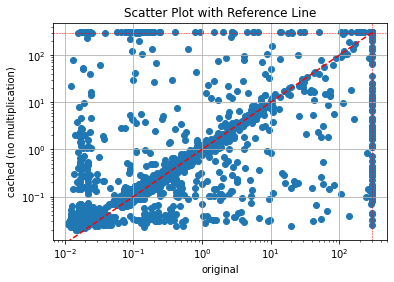

In [259]:
show_plot(orig_result, result, 'cputime')